In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import time
import numpy as np
from sklearn import metrics
from sklearn import linear_model
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
transform = transforms.Compose([transforms.ToTensor(),])
                                #transforms.Normalize((0.1307,), (0.3081,))])

trainset = datasets.MNIST('./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)

testset = datasets.MNIST('./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset,  batch_size=4, shuffle=True)

In [132]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3), 
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [133]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available(): print(torch.cuda.get_device_name(0))

Tesla K80


In [136]:
autoencoder = AutoEncoder().to(device)
criterion = nn.MSELoss()

In [139]:
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)
n = 500
for epoch in range(2):
    tmp=0
    for step, (x, label) in enumerate(train_loader):
        x, label = x.to(device),label.to(device)
        encoded, decoded = autoencoder(x.view(-1, 28*28))
        loss = criterion(decoded, x.view(-1, 28*28))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        tmp+=loss.item()
        if step%n == n-1:
            print(step,len(train_loader),tmp/n)
            tmp=0

499 15000 0.0378547337166965
999 15000 0.037443028450012204
1499 15000 0.03747977417334914
1999 15000 0.03758530837111175
2499 15000 0.03752957721240818
2999 15000 0.03735070521384477
3499 15000 0.03745855295285583
3999 15000 0.037031309310346844
4499 15000 0.03737496289424598
4999 15000 0.03701642127335072
5499 15000 0.03805931902676821
5999 15000 0.03680965966172516
6499 15000 0.03653017470985651
6999 15000 0.03715862655825913
7499 15000 0.0362178839892149
7999 15000 0.03673516898043454
8499 15000 0.03714368417672813
8999 15000 0.0367428810428828
9499 15000 0.036140213921666144


KeyboardInterrupt: 

In [123]:
class AutoEncoder_Conv(nn.Module):
    def __init__(self):
        super(AutoEncoder_Conv, self).__init__()
        self.conv1 = nn.Conv2d(1,4,3)
        self.conv2 = nn.Conv2d(4,10,3)
        self.fc1 = nn.Linear(10*5*5, 60)
        self.fc2 = nn.Linear(60,10)
        
        self.fc3 = nn.Linear(10, 60)
        self.fc4 = nn.Linear(60,10*5*5)
        self.conv3 = nn.ConvTranspose2d(10,4,3)
        self.conv4 = nn.ConvTranspose2d(4,1,3)
        
        self.dropout = nn.Dropout(0.2)
        self.unpool = nn.MaxUnpool2d(2, stride=2)
        
    def forward(self, x):
        x = self.dropout(F.relu(self.conv1(x))) #4,26,26
        x,indices1 = F.max_pool2d(x, 2, 2, return_indices=True) #4,13,13
        x = self.dropout(F.relu(self.conv2(x))) #10,11,11
        x,indices2 = F.max_pool2d(x, 2, 2, return_indices=True) #10,5,5
        x = x.view(-1,10*5*5)
        x = self.dropout(F.relu(self.fc1(x)))
        encoded = self.fc2(x)
        
        x = self.dropout(F.relu(self.fc3(encoded)))
        x = self.dropout(F.relu(self.fc4(x)))
        x = x.view(-1,10,5,5)
        x = self.unpool(x, indices=indices2, output_size=torch.Size([-1, 10, 11, 11]))
        x = self.dropout(F.relu(self.conv3(x)))
        x = self.unpool(x, indices=indices1, output_size=torch.Size([-1, 4, 26, 26]))
        decoded = self.conv4(x)
        return encoded, decoded

In [124]:
autoencoder_conv = AutoEncoder_Conv().to(device)
criterion = nn.MSELoss()

In [130]:
n = 500
optimizer = torch.optim.Adam(autoencoder_conv.parameters(), lr=0.001)
for epoch in range(2):
    tmp = 0
    for step, (x, label) in enumerate(train_loader):
        x, label = x.to(device),label.to(device)
        encoded, decoded = autoencoder_conv(x)
        loss = criterion(decoded, x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        tmp+=loss.item()
        if step%n == n-1:
            print(step,len(train_loader),tmp/n)
            tmp=0

499 15000 0.02888400765135884
999 15000 0.028779430631548166
1499 15000 0.028758681792765854
1999 15000 0.028908857537433504
2499 15000 0.02908941739052534
2999 15000 0.028395284652709962
3499 15000 0.028714566305279732
3999 15000 0.02874299100600183
4499 15000 0.02918004709854722
4999 15000 0.029308837816119194
5499 15000 0.028464038353413344


KeyboardInterrupt: 

In [99]:
def show_(s,autoencoder_conv):
    plt.subplot(121)
    plt.imshow(s.numpy()[0])
    
    plt.subplot(122)
    s = s.view(1,1,28,28)
    autoencoder_conv.eval()
    encoded, decoded = autoencoder_conv(s.to(device))
    plt.imshow(decoded.cpu().detach().numpy()[0][0])

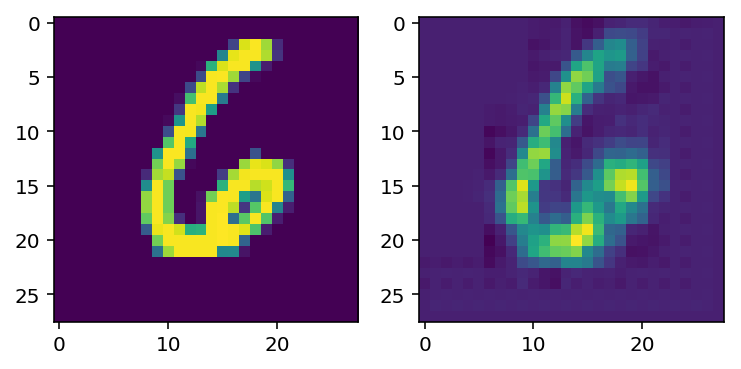

In [131]:
show_(trainset[151][0],autoencoder_conv)